# Demo LoFTR-DS on a single pair of images

This notebook shows how to use the loftr matcher with default config(dual-softmax) and the pretrained weights.

In [ ]:
print('Hello!')
import cv2

camera = cv2.VideoCapture(1)
if camera.isOpened():
    print('Camera open!')
    for i in range(10):
        return_value, image = camera.read()
        cv2.imwrite('test'+str(i)+'.png', image)
del(camera)
cv2.destroyAllWindows()

In [2]:
import os
os.chdir("..")
from copy import deepcopy

import torch
import cv2
import numpy as np
import matplotlib.cm as cm
from src.utils.plotting import make_matching_figure

# MPS acceleration is available on MacOS 12.3+
# pip install torch torchvision torchaudio

In [2]:
torch.device("mps")

device(type='mps')

In [3]:
device = torch.cuda.is_available()

In [4]:
torch.cuda.current_device()

AssertionError: Torch not compiled with CUDA enabled

In [5]:
torch.cuda.get_device_name(0)

AssertionError: Torch not compiled with CUDA enabled

## Indoor Example

In [3]:
from src.loftr import LoFTR, default_cfg

# The default config uses dual-softmax.
# The outdoor and indoor models share the same config.
# You can change the default values like thr and coarse_match_type.
_default_cfg = deepcopy(default_cfg)
_default_cfg['coarse']['temp_bug_fix'] = True  # set to False when using the old ckpt
matcher = LoFTR(config=_default_cfg)
matcher.load_state_dict(torch.load("weights/indoor_ds_new.ckpt")['state_dict'])
matcher = matcher.eval() #cuda()

In [13]:
# Load example images
img0_pth = "Dataset/1/1.PNG"
img1_pth = "Dataset/1/2.PNG"
# img0_pth = "assets/scannet_sample_images/scene0711_00_frame-001680.jpg"
# img1_pth = "assets/scannet_sample_images/scene0711_00_frame-001995.jpg"
img0_raw = cv2.imread(img0_pth, cv2.IMREAD_GRAYSCALE)
img1_raw = cv2.imread(img1_pth, cv2.IMREAD_GRAYSCALE)
img0_raw = cv2.resize(img0_raw, (640, 480))
img1_raw = cv2.resize(img1_raw, (640, 480))

img0 = torch.from_numpy(img0_raw)[None][None] / 255. #.cuda()
img1 = torch.from_numpy(img1_raw)[None][None] / 255.
batch = {'image0': img0, 'image1': img1}

# Inference with LoFTR and get prediction
with torch.no_grad():
    matcher(batch)
    mkpts0 = batch['mkpts0_f'].cpu().numpy()
    mkpts1 = batch['mkpts1_f'].cpu().numpy()
    mconf = batch['mconf'].cpu().numpy()

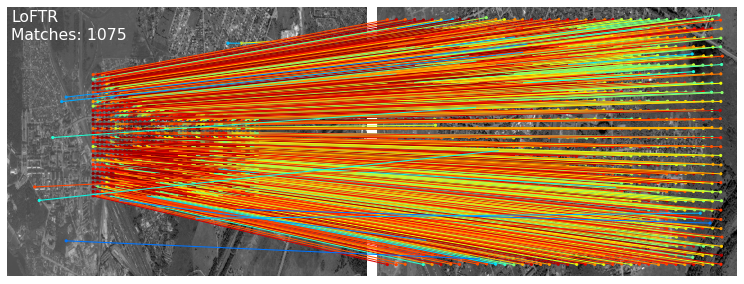

In [14]:
# Draw
color = cm.jet(mconf)
text = [
    'LoFTR',
    'Matches: {}'.format(len(mkpts0)),
]
fig = make_matching_figure(img0_raw, img1_raw, mkpts0, mkpts1, color, text=text)
fig.savefig('Dataset/1/loft/12.png')

## Outdoor Example

In [4]:
from src.loftr import LoFTR, default_cfg

# The default config uses dual-softmax.
# The outdoor and indoor models share the same config.
# You can change the default values like thr and coarse_match_type.
matcher = LoFTR(config=default_cfg)
matcher.load_state_dict(torch.load("weights/outdoor_ds.ckpt")['state_dict'])
matcher = matcher.eval().cuda()

AssertionError: Torch not compiled with CUDA enabled

In [19]:
default_cfg['coarse']

{'d_model': 256,
 'd_ffn': 256,
 'nhead': 8,
 'layer_names': ['self',
  'cross',
  'self',
  'cross',
  'self',
  'cross',
  'self',
  'cross'],
 'attention': 'linear',
 'temp_bug_fix': True}

In [17]:
# Load example images
img0_pth = "assets/phototourism_sample_images/united_states_capitol_26757027_6717084061.jpg"
img1_pth = "assets/phototourism_sample_images/united_states_capitol_98169888_3347710852.jpg"
img0_raw = cv2.imread(img0_pth, cv2.IMREAD_GRAYSCALE)
img1_raw = cv2.imread(img1_pth, cv2.IMREAD_GRAYSCALE)
img0_raw = cv2.resize(img0_raw, (img0_raw.shape[1]//8*8, img0_raw.shape[0]//8*8))  # input size shuold be divisible by 8
img1_raw = cv2.resize(img1_raw, (img1_raw.shape[1]//8*8, img1_raw.shape[0]//8*8))

img0 = torch.from_numpy(img0_raw)[None][None].cuda() / 255.
img1 = torch.from_numpy(img1_raw)[None][None].cuda() / 255.
batch = {'image0': img0, 'image1': img1}

# Inference with LoFTR and get prediction
with torch.no_grad():
    matcher(batch)
    mkpts0 = batch['mkpts0_f'].cpu().numpy()
    mkpts1 = batch['mkpts1_f'].cpu().numpy()
    mconf = batch['mconf'].cpu().numpy()

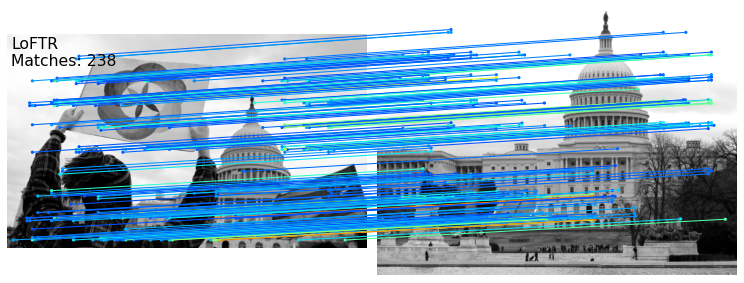

In [18]:
# Draw
color = cm.jet(mconf)
text = [
    'LoFTR',
    'Matches: {}'.format(len(mkpts0)),
]
fig = make_matching_figure(img0_raw, img1_raw, mkpts0, mkpts1, color, text=text)